## Training a Neural Network Using Keras in TensorFlow

In this demo, we will show you how to train a neural network using Keras in TensorFlow. We will implement a neural network for binary classification with three hidden layers and train the network using a form of the optimization algorithm gradient descent called stochastic gradient descent (SGD).

For more information about Keras, consult the [online documentation](https://keras.io/api/).
TensorFlow is a general purpose high-performance computing language which Keras is built on top of to allow us to easily define and train neural networks.

To get started, let us import Keras, along with other libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import time

### Create and Visualize a Data Set

We will create some data to use for training and testing.

Our data set consists of 600 examples. Each example contains two features `x1` and `x2`. The label `y` is either 0 or 1. For this demo, we created our data set to contain 300 examples belonging to class 0 and 300 examples belonging to class 1.

Run the code cells below to inspect and visualize the data.

In [2]:
# The data contains 600 examples total
# 300 in class 0 
# 300 in class 1

# Generate the raw data
N = 300
r = np.linspace(1,2*np.pi,N)
x1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
x2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T

# Compute X and y
X = np.concatenate([x1, x2], axis=0)
print("X shape:")
print(X.shape)
y = np.concatenate([np.ones(N), 0 * np.ones(N)])

# Create DataFrame for visualizaton purposes
df = pd.DataFrame({
    'x1': X[:,0],
    'x2': X[:,1],
    'y': y
})
df.head()

X shape:
(600, 2)


,x1,x2,y
0,0.909297,-0.416147,1.0
1,0.909824,-0.455930,1.0
2,0.908654,-0.496261,1.0
3,0.905752,-0.537067,1.0
4,0.901081,-0.578277,1.0


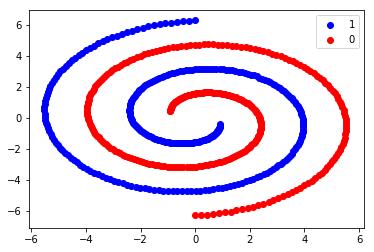

In [3]:
# Visualize data
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b')
plt.scatter(X[y != 1, 0], X[y != 1, 1], c='r')
plt.legend(["1","0"])
plt.show()

### Create Training & Test Data Sets
We will now use `sklearn` to split our data set into training and test data sets.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
print(X_train.shape)
print(X_test.shape)

(420, 2)
(180, 2)


The steps to define and train a neural network using Keras are:

1. Define the model structure.
2. Define the optimization algorithm, i.e., the variant of gradient descent you want to use.
3. Define the loss function to minimize.
4. Compile the model.
5. "Fit" the model on training data for $M$ epochs (training cycles).
6. Evaluate the model.

The "fitting" process propagates the data forward in the network, computes the loss value, computes the gradients for the weights, and updates the weights for $M$ times. 

We will walk you through those steps.

### Step 1. Define Model Structure

We will use the Keras [Sequential class](https://keras.io/api/models/sequential/) to group a stack of layers. We will use the [Dense class](https://keras.io/api/layers/core_layers/dense/) to create each layer. 

To create a neural network in Keras we have to specify the type and width of each hidden layer as well as the activation function utilized. Below we create a network with 3 hidden layers of width 64, 32, and 16 and utilizing the ReLu activation function.


In [5]:
model = keras.Sequential()

hidden_layer_1 = keras.layers.Dense(units=64, input_shape=(2,), activation='relu', name='fc1')
model.add(hidden_layer_1)

hidden_layer_2 = keras.layers.Dense(units=32, activation='relu', name='fc2')
model.add(hidden_layer_2)

hidden_layer_3 = keras.layers.Dense(units=16, activation='relu', name='fc3')
model.add(hidden_layer_3)

output_layer = keras.layers.Dense(units=2, activation=None, name='fc4')
model.add(output_layer)

Let's break this down. Our network is comprised of 5 layers: an input layer, three hidden layers and an output layer.
The code above creates the hidden and output layers.

<b>Hidden layer</b>

We pass the following arguments to the `Dense()` function:

`input_shape`: dimensionality of the input layer.<br>

* When specifying an input shape of 2, we are specifying the input layer's dimensions. The input layer should have 2 dimensions to match the feature dimension of each of the training examples in $\mathbf{X}$.
    
`activation`: activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).<br>

* In this demo, we are specifying `ReLU` as the activation function. 

`units`: dimensionality of the output space. We can view this as the number of nodes in the layer itself.<br>

   *  When specifying the number of units in the first hidden layer to be 64, we are specifying a fully-connected layer with 64 hidden units (nodes). Note that we can choose the value of `units`. This is a hyperparmeter we can tune.


<b>Output Layer</b>:
- The output layer is a single dense layer. The output shape must be the number of classes. Since our model is a binary classification model, we specify 2 units.  


### Step 2. Define the Optimization Algorithm

As our optimizer we will use stochastic gradient descent (SGD) with a learning rate of 0.1.

Keras does not provide vanilla gradient descent. Instead, the basic variant it provides is Stochastic Gradient Descent (SGD). For more information, see the [SGD online documentation](https://keras.io/api/optimizers/sgd/). 

In [6]:
optimizer = keras.optimizers.SGD(learning_rate=0.1)

### Step 3. Define the Loss Function

Since we are working with a binary classification problem, we are going to use cross entropy loss. We will use the `SparseCategoricalCrossentropy` loss function since `y` contains integer labels (0 and 1).
Since the outputs will be not normalized between 0 and 1, we specify `from_logits=True`. For more information on cross entropy loss functions in Keras visit the [online documentation](https://keras.io/api/losses/probabilistic_losses/).

In [7]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### Step 4. Compile the model

Now we need to package the network architecture with the optimizer and the loss function and to do this we use the `.compile()` method. Notice we are also including the `metrics` parameter. This is a list of metrics to be evaluated by the model during training and testing. We will specify `accuracy` since we would like to obtain the accuracy score.

In [8]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

### Step 5. Fit the Model on the Training Data

We are almost ready to train the neural network model. By default, Keras outputs loss and metrics at the end of every epoch. So instead, we will use a custom logger function to only output every 50 epochs.

In [9]:
class ProgBarLoggerNEpochs(keras.callbacks.Callback):
    
    def __init__(self, num_epochs: int, every_n: int = 50):
        self.num_epochs = num_epochs
        self.every_n = every_n
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n == 0:
            s = 'Epoch [{}/ {}]'.format(epoch + 1, self.num_epochs)
            logs_s = ['{}: {:.4f}'.format(k.capitalize(), v)
                      for k, v in logs.items()]
            s_list = [s] + logs_s
            print(', '.join(s_list))

Now we can run the `.fit()` method on our model to learn model parameters from the training data. Notice we are adding our logger function to the list of callbacks.

In [10]:
t0 = time.time() # start time

num_epochs_M = 1000

history = model.fit(
    X_train,
    y_train,
    epochs=num_epochs_M,
    verbose=0, # disable the default progress bar
    callbacks=[ProgBarLoggerNEpochs(num_epochs_M, every_n=50)],
)

t1 = time.time() # stop time

print('Elapsed time: %.2fs' % (t1-t0))

Epoch [50/ 1000], Loss: 0.6149, Accuracy: 0.6381
Epoch [100/ 1000], Loss: 0.1021, Accuracy: 0.9976
Epoch [150/ 1000], Loss: 0.0088, Accuracy: 1.0000
Epoch [200/ 1000], Loss: 0.0017, Accuracy: 1.0000
Epoch [250/ 1000], Loss: 0.0008, Accuracy: 1.0000
Epoch [300/ 1000], Loss: 0.0004, Accuracy: 1.0000
Epoch [350/ 1000], Loss: 0.0003, Accuracy: 1.0000
Epoch [400/ 1000], Loss: 0.0002, Accuracy: 1.0000
Epoch [450/ 1000], Loss: 0.0002, Accuracy: 1.0000
Epoch [500/ 1000], Loss: 0.0002, Accuracy: 1.0000
Epoch [550/ 1000], Loss: 0.0001, Accuracy: 1.0000
Epoch [600/ 1000], Loss: 0.0001, Accuracy: 1.0000
Epoch [650/ 1000], Loss: 0.0001, Accuracy: 1.0000
Epoch [700/ 1000], Loss: 0.0001, Accuracy: 1.0000
Epoch [750/ 1000], Loss: 0.0001, Accuracy: 1.0000
Epoch [800/ 1000], Loss: 0.0001, Accuracy: 1.0000
Epoch [850/ 1000], Loss: 0.0001, Accuracy: 1.0000
Epoch [900/ 1000], Loss: 0.0001, Accuracy: 1.0000
Epoch [950/ 1000], Loss: 0.0001, Accuracy: 1.0000
Epoch [1000/ 1000], Loss: 0.0001, Accuracy: 1.0000


It is possible that the Keras model takes longer to train than a version built from scratch with basic Numpy. This is because of the massive overhead required to setup and train the model. However, as the number of training examples increases and the network becomes more complex, Keras (and other Machine Learning libraries) scale much better than pure-Numpy implementations---even better when you use a GPU. For this reason, developers and researchers almost always use libraries like TensorFlow and Keras to train networks.

### Step 6. Evaluate the Model

Let us visualize the training loss over time:

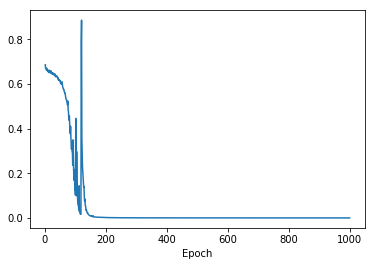

In [11]:
# visualize the training loss over time
training_losses = history.history['loss']

plt.plot(range(1, num_epochs_M + 1), training_losses, label='Training Loss')

plt.xlabel('Epoch')
plt.show()

Keras makes the process of evaluating our model very easy. Recall that when we compiled the model we specified the metric we wanted to use to evaluate the model: accuracy. The keras method `.evaluate()` will return the loss and accuracy score of our model on our test data:

In [12]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Loss: ', str(loss) , 'Accuracy: ', str(accuracy))

Loss:  0.00011634334805421531 Accuracy:  1.0


Classification problems output belief vectors, also known as logits. Every element in the belief vector corresponds to the model's belief that the input example belongs to a certain class. For example, imagine we have a 5-class classification problem with labels {0, 1, 2, 3, 4}. Our model will output a 5-dimensional belief vector. If the 𝑗th element of this vector has the highest value, then the model believes that that data point belongs to class 𝑗.

We are working with binary classification, so for each example, the model will output a 2-dimensional belief vector. The element (element 0 or element 1) in the two dimensional vector that has the highest value is the class (class 0 or class 1) that the model believes the example belongs to.

In the cell below, we will make a prediction on our test set using the `.predict()` method, receive an output of logits, and then apply the `.argmax(axis=1)` method to get the predicted class for each example.

For the first 5 examples, we will output their 2-dimensional belief vectors and the corresponding classes. Examine the output to see how this works.

In [13]:
# Evaluate the network
# Make predictions on the test set
logits = model.predict(X_test)
pred = logits.argmax(axis = 1)

print("Predictions for the first 5 examples:")
print("Logits\t\t\tClass")
for i in range(0,5):
    print(str(logits[i]) + "\t" + str(pred[i]))

Predictions for the first 5 examples:
Logits			Class
[ 6.129758 -4.08481 ]	0
[ 5.189875  -3.8784604]	0
[ 6.709298  -3.1148262]	0
[ 5.93895  -4.117408]	0
[-3.9945073  5.961591 ]	1


Although we already computed the accuracy score using the `.evaluate()` method, we can verify the accuracy by comparing our resulting predictions to the labels contained in our test set `y_test`.

In [14]:
acc = np.equal(pred,y_test).mean()
print('Test Accuracy is {:.4f}'. format(acc))

Test Accuracy is 1.0000


### Step 7. Visualize the Learned Decision Boundaries

Finally, since this example is a binary classification problem, we can visualize the decision boundaries that the model learned:

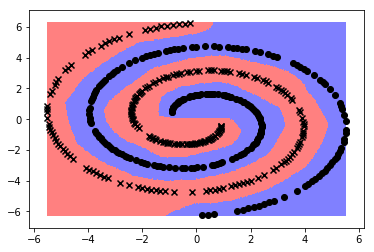

In [15]:
from numpy.matlib import repmat

symbols = ["ko","kx"]
marker_symbols = ['o', 'x']
mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
classvals = np.unique(y_train)

plt.figure()

res=300
xrange = np.linspace(min(X_test[:, 0]), max(X_test[:, 0]),res)
yrange = np.linspace(min(X_test[:, 1]), max(X_test[:, 1]),res)
pixelX = repmat(xrange, res, 1)
pixelY = repmat(yrange, res, 1).T


xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T
logits = model.predict(xTe, steps = 1)
testpreds = logits.argmax(axis = 1)

testpreds[testpreds == 0] = -1
Z = testpreds.reshape(res, res)
#Z[0,0] = 1 # optional: scale the colors correctly
plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

for idx, c in enumerate(classvals):
    plt.scatter(X_train[y_train == c,0],
                X_train[y_train == c,1],
                marker=marker_symbols[idx],
                color='k')

plt.axis('tight')
plt.show()



<b>Analysis (ungraded)</b>:

You can play around with the neural network implementation above and compare your results every time you train the network. Pay attention to the time it takes to train the network, and the resulting loss. 

Below are some ideas for things you can try:

* Adjust the learning rate.
* Change the number of Epochs ($M$) by experimenting with different values for the variable `num_epochs_M`.
* Add more hidden layers and/or experiment with different values for the `unit` parameter in the hidden layers to change the number of nodes in the hidden layers.
* Modify the data set.